In [28]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning

In [29]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
# df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
# df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [30]:
# cleaning some movies columns 
df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning.clean_idxs)
df_movies['countries'] = df_movies['countries'].apply(cleaning.clean_idxs)
df_movies['genres'] = df_movies['genres'].apply(cleaning.clean_idxs)

# clean movies dates to keep the release year only
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)

In [31]:
# clean characters dates to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

At this point df_movies and df_characters are cleaned and their size did not change

In [32]:
# extracting and sorting release years
release_years = df_movies['release_date'].unique()
release_years.sort()

Text(0.5, 1.0, 'Movies distribution by release date')

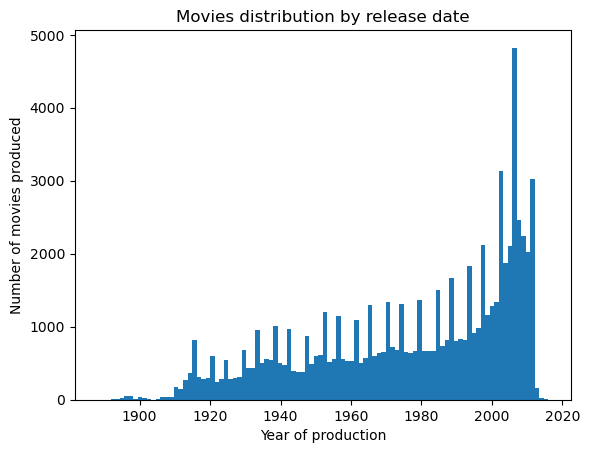

In [33]:
# filtering movies release dates (first ever produced movie: 1888)
df_movies_release = df_movies[df_movies['release_date'] > 1887]

# movies distribution wrt release date
plt.figure()
plt.hist(df_movies_release['release_date'], bins= 100)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.title('Movies distribution by release date')


In [34]:
# defining a dataframe with non-nan revenues, observe that 90% of the
# original revenue values are missing --> losing a lot of data
df_movies_revenue = df_movies.dropna(subset=['revenue'])

# filtering release dates
df_movies_revenue = df_movies_revenue[df_movies_revenue['release_date'] > 1887]

Text(0, 0.5, 'Revenue (USD)')

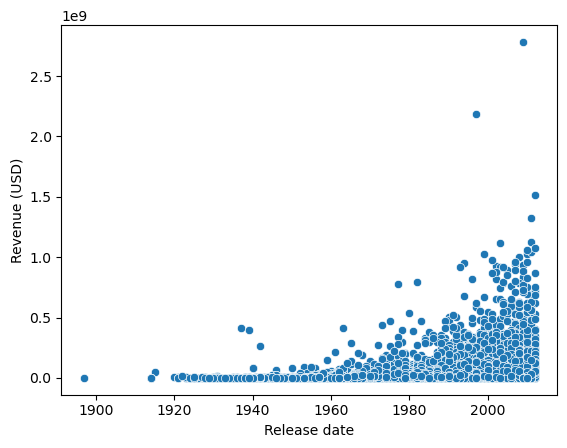

In [35]:
# scatter-plots to assess possible regressions
# revenue-release_date
sns.scatterplot(x='release_date', y='revenue', data=df_movies_revenue)
plt.xlabel("Release date")
plt.ylabel("Revenue (USD)")

In [ ]:
# linear regression (even tho data is hardly linearly fittable)
mod = smf.ols(formula='revenue ~ release_date', data=df_movies_revenue)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     296.8
Date:                lun, 04 nov 2024   Prob (F-statistic):           2.25e-65
Time:                        00:15:06   Log-Likelihood:            -1.6604e+05
No. Observations:                8327   AIC:                         3.321e+05
Df Residuals:                    8325   BIC:                         3.321e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.058e+09   1.22e+08    -16.831   

Text(0, 0.5, 'Revenue (USD)')

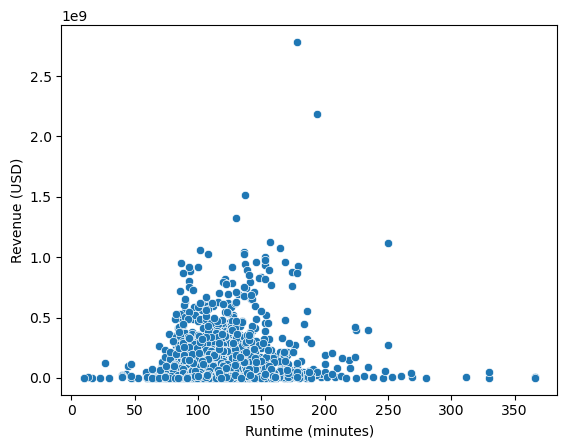

In [25]:
# on runtime movies need to be filtered (arbitrary limit, needs to be investigated)
df_movies_revenue = df_movies_revenue[df_movies_revenue['runtime'] < 400]

# revenue-runtime
sns.scatterplot(x='runtime', y='revenue', data=df_movies_revenue)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (USD)")

In [ ]:
# linear regression (even tho data is hardly linearly fittable)
mod = smf.ols(formula='revenue ~ runtime', data=df_movies_revenue)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     303.3
Date:                lun, 04 nov 2024   Prob (F-statistic):           9.90e-67
Time:                        00:17:14   Log-Likelihood:            -1.6436e+05
No. Observations:                8242   AIC:                         3.287e+05
Df Residuals:                    8240   BIC:                         3.287e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.696e+07   5.61e+06     -8.368      0.0

In [42]:
# linear regression with both release_date and runtime, without interaction
mod = smf.ols(formula='revenue ~ runtime + release_date', data=df_movies_revenue)
res = mod.fit()
print(res.summary())

# linear regression with both release_date and runtime, with interaction
mod = smf.ols(formula='revenue ~ runtime * release_date', data=df_movies_revenue)
res = mod.fit()
print(res.summary())

# there is interaction between the two terms, needs to be investigated

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     293.4
Date:                lun, 04 nov 2024   Prob (F-statistic):          8.50e-124
Time:                        00:20:16   Log-Likelihood:            -1.6422e+05
No. Observations:                8242   AIC:                         3.285e+05
Df Residuals:                    8239   BIC:                         3.285e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.063e+09   1.22e+08    -16.903   